In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# part1

In [2]:

datapath= './short_questions/1a.npy'
source= np.load(datapath).reshape(10, 2)

datapath= './short_questions/1b.npy'
target = np.load(datapath).reshape(10, 2)  
data_num = source.shape[0]

#print(source)
#print(target)
A = np.zeros((data_num*2, 6))
b = np.zeros((data_num*2, 1))
for i in range(data_num):
    A[i*2 , 0:2] = source[i][0:2]
    A[i*2 , 2] = 1.0
    b[i*2] = target[i,0]
    
    A[i*2+1 , 3:5] = source[i][0:2]
    A[i*2+1 , 5] = 1.0
    b[i*2+1] = target[i,1]
    
t =  np.linalg.inv(np.transpose(A) @ A) @ np.transpose(A) @ b

T = np.zeros((3,3),dtype = np.float)
T[0:2 , : ] = t.reshape(2,3)
T[2,2] = 1.0
print("affine transformation")
print(T)



affine transformation
[[2.  3.  7. ]
 [1.5 1.  8.7]
 [0.  0.  1. ]]


In [3]:
print("check")
for i in range(data_num):
    check = np.zeros( (1,3))
    check[0,0:2] = source[i,:]
    check[0,2] = 1.0
    check = np.transpose(check)
    result = T @ check
    result = np.transpose(result)
    print("result")
    print(result[0,0:2])
    print("target")
    print(target[i,:])


check
result
[-7.07758324  4.26041664]
target
[-7.07758324  4.26041664]
result
[ 2.07104131 10.906895  ]
target
[ 2.07104131 10.906895  ]
result
[10.62703709 13.3920624 ]
target
[10.62703709 13.3920624 ]
result
[12.60382819 11.86785494]
target
[12.60382819 11.86785494]
result
[-7.65138398  0.12442313]
target
[-7.65138398  0.12442313]
result
[1.63011275 5.46161345]
target
[1.63011275 5.46161345]
result
[-8.83809479  1.78960547]
target
[-8.83809479  1.78960547]
result
[19.45995764 15.98888992]
target
[19.45995764 15.98888992]
result
[17.88921907 14.6106223 ]
target
[17.88921907 14.6106223 ]
result
[20.24461902 15.7981203 ]
target
[20.24461902 15.7981203 ]


# part2

homography

In [4]:
datapath= './short_questions/2a.npy'
source= np.load(datapath).reshape(-1, 2)

datapath= './short_questions/2b.npy'
target = np.load(datapath).reshape(-1, 2)  
data_num = source.shape[0]

#print(source.shape)
#print(target.shape)
A = np.zeros((data_num*2, 9))
b = np.zeros((data_num*2, 1))
for i in range(data_num):
    A[i*2 , 0:2] = source[i , 0:2]
    A[i*2 , 2] = 1.0
    A[i*2 , 6:8] = -1*target[i,0]*source[i , 0:2]
    A[i*2 , 8] = -1*target[i,0]
        
    A[i*2+1 , 3:5] = source[i , 0:2]
    A[i*2+1 , 5] = 1.0
    A[i*2+1 , 6:8] = -1*target[i,1]*source[i , 0:2]
    A[i*2+1 , 8] = -1*target[i,1]
u, s, vh = np.linalg.svd(A, full_matrices=True)
t = vh[-1, :] / vh[-1, -1]
p = t.reshape(3, 3)
print("homography")
print(p)

#to check the homography

for i in range(data_num):
    #print(source[i])
    tmp = np.array([source[i,0] , source[i,1] , 1])
    tmp = tmp.T
    mapped = p @ tmp
    mapped /= mapped[2]
    #print(mapped)
    #print(target[i])


homography
[[1.00000000e+00 1.00000000e+00 5.00000000e+00]
 [8.00000000e+00 7.00000000e+00 1.00000000e+01]
 [3.38109230e-16 2.35071221e-16 1.00000000e+00]]


# part 3

In [5]:
def cal_homography(source , target):
    data_num = source.shape[0]
    A = np.zeros((data_num*2, 9))
    b = np.zeros((data_num*2, 1))
    for i in range(data_num):
        A[i*2 , 0:2] = source[i , 0:2]
        A[i*2 , 2] = 1.0
        A[i*2 , 6:8] = -1*target[i,0]*source[i , 0:2]
        A[i*2 , 8] = -1*target[i,0]

        A[i*2+1 , 3:5] = source[i , 0:2]
        A[i*2+1 , 5] = 1.0
        A[i*2+1 , 6:8] = -1*target[i,1]*source[i , 0:2]
        A[i*2+1 , 8] = -1*target[i,1]
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    t = vh[-1, :] / vh[-1, -1]
    p = t.reshape(3, 3)
    
    return p

In [6]:
datapath= './short_questions/3a.npy'
source= np.load(datapath).reshape( -1, 2)

datapath= './short_questions/3b.npy'
target = np.load(datapath).reshape( -1, 2)  
data_num = source.shape[0]


##### RANSAC

# Some parameters
num_samples = 5
num_trials = 3000
total_matches = data_num
inlier_thresh = 1.0

# To keep track of the best transformation
xform = np.zeros((3, 3))
most_inliers = 0

# Loop through num_trials times
for i in range(num_trials):

    # Randomly choose num_samples indices from total number of matches
    choices = np.random.choice(total_matches, num_samples, replace=False)

    # Get the matching keypoint coordinates from those indices
    keypoints1 = source[choices]
    keypoints2 = target[choices]
    #print(keypoints1)
    #print(keypoints2)
    
    # Use getAffineTransform to get our transformation matrix
    M = cal_homography( keypoints1 , keypoints2 )
    
    transformation = M.reshape(3,3)
    #print(transformation)
    num_inliers = 0

      # Loop through all of our matches
    for j in range(total_matches):
        
        tmp = np.array([source[j,0] , source[j,1]  , 1])
        tmp = tmp.T
        exp_coord = transformation @ tmp
        exp_coord /= exp_coord[2]
        
        dif = np.linalg.norm(exp_coord[0:2] - target[j , 0:2 ])
        if inlier_thresh > dif:
            num_inliers = num_inliers+1

      # If for this transformation we have found the most inliers update most_inliers and xform
    if num_inliers > most_inliers:
        most_inliers = num_inliers
        xform = np.copy(np.float32(transformation))
print("homography found by RANSAC")
print(xform)
        

homography found by RANSAC
[[2.0000000e+00 6.0000000e+00 6.0000000e+00]
 [4.0000000e+00 5.0000000e+00 3.0000000e+00]
 [2.4269744e-16 9.6801000e-16 1.0000000e+00]]


In [7]:
for i in range(data_num):
    #print(source[i])
    tmp = np.array([source[i,0] , source[i,1], 1])
    tmp = tmp.T
    mapped = xform @ tmp
    mapped /= mapped[2]
    print(mapped)
    print(target[i])
print("match number")
print(most_inliers)

[22.0704699  13.18267276  1.        ]
[22.0704699  13.18267276]
[23.31737329 27.43277103  1.        ]
[23.31737329 27.43277103]
[10.62641542  3.21077451  1.        ]
[10.62641542  3.21077451]
[23.86910371 11.16423238  1.        ]
[23.86910371 11.16423238]
[6.8622206  3.49830311 1.        ]
[6.8622206  3.49830311]
[-1.0739669   7.07701246  1.        ]
[-1.0739669   7.07701246]
[7.73086207 6.56405659 1.        ]
[7.73086207 6.56405659]
[10.1349595   6.27559078  1.        ]
[10.1349595   6.27559078]
[12.58426441 16.34372905  1.        ]
[12.58426441 16.34372905]
[37.28747888 37.37296006  1.        ]
[37.28747888 37.37296006]
[3.21539896 5.7126553  1.        ]
[4.39852144 2.16328785]
[-0.25163398  1.09503664  1.        ]
[ 1.26240953 -3.44709391]
[27.45154625 25.65847266  1.        ]
[24.5594577 34.3347383]
[2.52422294 6.37673285 1.        ]
[3.99969251 1.95032415]
[-6.93987117  3.13975913  1.        ]
[-3.22279953 -8.01145579]
match number
10


# part4

(array([ 1.68195599,  4.13864855, 25.95054877,  0.        , 19.62930944,
         5.66959413,  6.59930367,  0.        ,  7.25646004,  0.        ]),
 array([-1.57079633, -1.25663706, -0.9424778 , -0.62831853, -0.31415927,
         0.        ,  0.31415927,  0.62831853,  0.9424778 ,  1.25663706,
         1.57079633]),
 <a list of 10 Patch objects>)

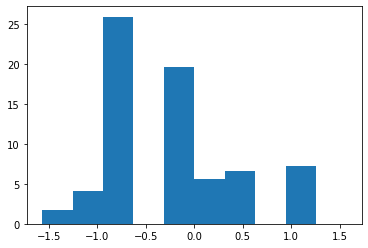

In [8]:
datapath= './short_questions/gradients.npy'
gradients = np.load(datapath).reshape( 20, -1)
data_num = 20

magnitude = np.sqrt( (gradients[ :,0 ] * gradients[ :,0 ]) + (gradients[ :,1 ] * gradients[ :,1 ]))
#print(magnitude.shape)
magnitude = magnitude.reshape(20,1)
orientation = np.zeros((20,1),dtype = np.float)
for i in range(data_num):
    tmp = gradients[i,0]
    if( np.abs(gradients[i,0]) <1e-6): tmp = 1e-6
    orientation[i] = np.arctan( gradients[i,1] / tmp )
#hist , edge 
plt.hist( orientation , bins = 10 , range = (-np.pi/2 , np.pi/2) ,weights = magnitude)
#for i in range(data_num):
#plt.hist2d(x = gradients[:,0] , y = gradients[:,1] , bins=10)

# part5

./data/bikes1.png


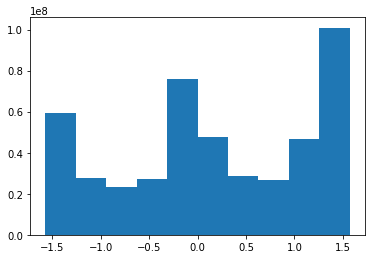

./data/graf1.png


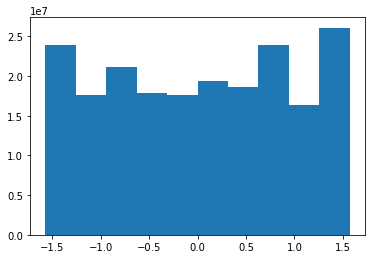

./data/leuven1.png


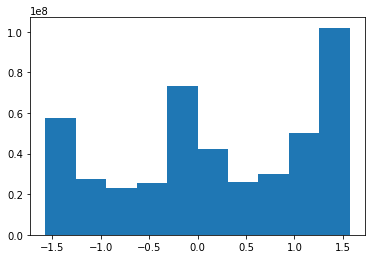

./data/wall1.png


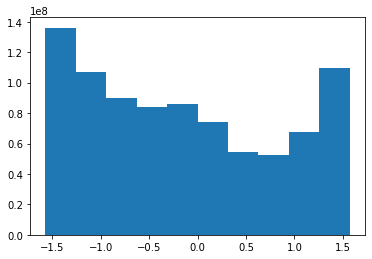

In [12]:
'''

bikes1.png
graf1.png
leuven1.png
wall1.png
'''
import cv2
def get_histogram(filename):
    print(filename)
    image = cv2.imread(filename)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    filter_size = 5
    
    gradient_x = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=filter_size)
    gradient_y = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=filter_size)
    magnitude = np.sqrt( (gradient_x * gradient_x) + (gradient_y * gradient_y) )
    #print(magnitude.shape)
    gradient_x[ np.abs(gradient_x) < 1e-6 ] = 1e-6
    orientation = np.arctan( gradient_y / gradient_x  )
    
    orientation = orientation.reshape(-1,1)
    magnitude = magnitude.reshape(-1,1)
    plt.hist( orientation , bins = 10 , range = (-np.pi/2 , np.pi/2) ,weights = magnitude)
    plt.show()
    
filenames = ['bikes1.png' ,'graf1.png', 'leuven1.png', 'wall1.png']
path = './data/'
for file in filenames: 
    get_histogram(path+file)
    
    